In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as sk

import warnings

# Ignorieren von FutureWarnings 
warnings.simplefilter(action='ignore', category=FutureWarning)

# 1. Business Understanding

Die Folgenden Ziele sind ausgerichtet auf mittelfristigen Investoren mit einer Investitionsdauer von maximal 1–2 Jahren. 

1. **Identifikation von unterbewerteten Immobilien:** Das primäre Ziel des Regressionsmodells ist die präzise Vorhersage des fairen Verkaufspreises. Durch den Vergleich der Modellvorhersage mit den tatsächlichen Angebotspreisen sollen Häuser identifiziert werden, die signifikant unter dem Marktwert angeboten werden.

2. **Ermittlung von Renovierungsmaßnahmen:** Durch die Analyse der Einflussfaktoren soll ermittelt werden, welche Merkmale den größten Einfluss auf den Verkaufspreis haben. Das Ziel ist es, abzuleiten, welche der Renovierungsmaßnahmen den Wert eines Hauses am stärksten steigern, um es innerhalb des Anlagezeitraums gewinnbringend weiterzuverkaufen. Ein Beispiel für eine solche Maßnahme wäre möglicherweise die verbesserung der Qualität des Innenanstrichs des Hauses.

# 2. Data Exploration und Analyse

In [7]:
# Daten Einlesen
data_train = pd.read_csv('data_for_training.csv', sep=';')

# Erste 10 Datensätze ausgeben
data_train.head(10)

,A_Index,Ausbaustufe,Baujahr,Besonderheiten,EG_qm,Gesamtqual,Gesamtzustand,Grundstueck_qm,Kellerhoehe,Lage,QualInnenfarbe,Steigung,Umgebaut,Verkaufsjahr,Wohnflaeche_qm,Z_Verkaufspreis
0,1710,1 Ebene,1960,NaN,166,Durchschnitt,Durchschnitt,1428,Durchschnitt,NeuBerlin_B,3,Keine/Kaum,1960,2009,166,100088
1,1310,1 Ebene,1982,NaN,151,Durchschnitt,Durchschnitt,2365,Gut,NeuBerlin_B,2,Mittel,1982,2006,151,145148
2,2563,1 Ebene,1925,NaN,84,Schlecht,Schlecht,1004,Schlecht,NeuBerlin_A,3,Stark,1953,2011,84,48860
3,373,1 Ebene,1968,NaN,95,Durchschnitt,Durchschnitt,1314,Durchschnitt,NeuBerlin_C,5,Keine/Kaum,1968,2006,95,72349
4,1464,1 Ebene,1979,NaN,133,Gut,Gut,1080,Gut,NeuBerlin_C,5,Keine/Kaum,2007,2007,133,138313
5,776,"1,5 Ebenen",1951,NaN,114,Durchschnitt,Durchschnitt,962,Durchschnitt,NeuBerlin_C,2,Keine/Kaum,1953,2005,155,76230
6,1874,1 Ebene,1954,NaN,124,Durchschnitt,Durchschnitt,931,Schlecht,NeuBerlin_A,4,Keine/Kaum,1954,2008,124,84066
7,65,2 Ebenen,2003,NaN,70,Gut,Durchschnitt,217,Gut,NeuBerlin_A,1,Keine/Kaum,2003,2007,140,106907
8,2289,1 Ebene,1999,NaN,102,Durchschnitt,Durchschnitt,1660,Gut,NeuBerlin_B,2,Mittel,1999,2007,102,93837
9,2390,1 Ebene,1977,Pool,200,Gut,Schlecht,1440,Gut,NeuBerlin_C,2,Keine/Kaum,1977,2006,246,155623


Spalten: A_Index, Ausbaustufe, Baujahr, Besonderheiten, EG_qm, Gesamtqual, Gesamtzustand, Grundstueck_qm, Kellerhoehe, Lage, QualInnenfarbe, Steigung, Umgebaut, Verkaufsjahr, Wohnflaeche_qm, Z_Verkaufspreis

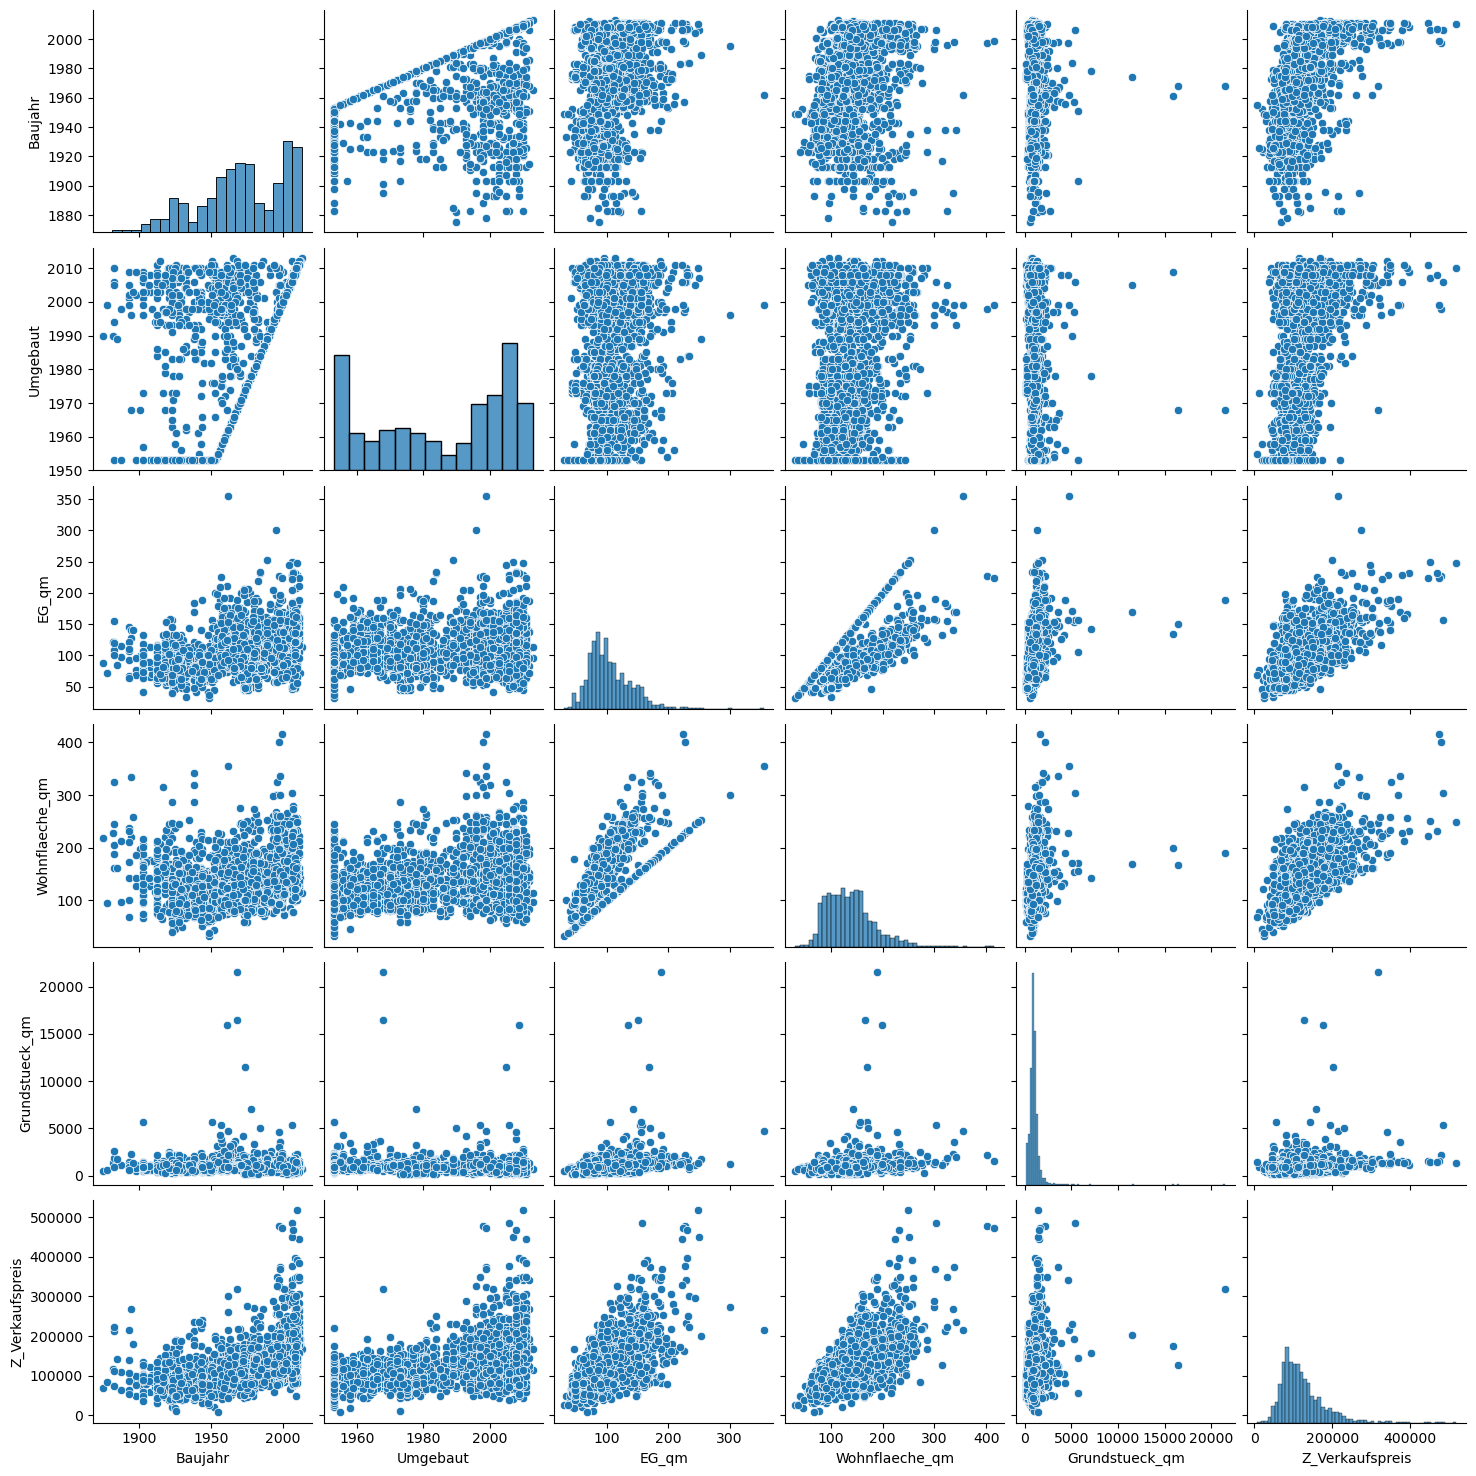

In [8]:
# Wähle gezielte numerische Spalten
land_vs_price = ['Baujahr', 'Umgebaut', 'EG_qm', 'Wohnflaeche_qm', 'Grundstueck_qm', 'Z_Verkaufspreis']

# Scatterplot erstellen
scatterplot = sns.pairplot(data_train[land_vs_price])
scatterplot

Basierend auf den allgemeinen Scatterplots, welche die Numerischen Zusammenhänge darstellen, lassen sich folgende Hypothesen und Handlungen ableiten:

- **Preistreiber:** Es ist eine positive Korrelation zwischen `Wohnflaeche_qm` und dem `Z_Verkaufspreis` erkennbar
    - Die Beziehung wirkt weitgehend linear, zeigt aber bei sehr großen Flächen eine zunehmende Varianz
    - `EG_qm` scheint aus den selben gründen positiv mit `Z_Verkaufspreis` korreliert zu sein
- **Ausreißer:** Das Feature `Grundstueck_qm` zeigt massive Ausreißer (einzelne Punkte weit rechts von 5.000qm, jedoch Großteil der Daten < 5.000qm). Diese Ausreißer stauchen die Skala und erschweren das Lernen für lineare Modelle
    - Diese Ausreißer sind zu entfernen, oder zumindest auch zuvor ohne diese zu betrachten, um daraufhin eine Entscheidung über das Vorgehen treffen zu können
- **Alter und Preis:** Neuere Häuser (`Baujahr`) scheinen eher höhere Preise zu haben, die Streuung ist jedoch groß. Vermutbar ist, dass das Baujahr allein nicht reicht und allgemeine Zustand des Hauses (`Gesamtqual` und `Gesamtzustand`), sowie ob das Gebäude Rennoviert wurde (`Umgebaut`) ebenfalls eine Rolle spielt
    - Diese möglichen Zusammenhänge sind zu überprüfen
 - **Umbau:** Das Merkmal `Umgebaut` scheint sich ähnlichen Einfluss auf den Verkaufspreis wie das Merkmal `Baujahr` zu haben. Da Häuser, welche bisher nicht umgebaut wurden hier ihr Baujahr eingetragen haben erscheint dies auch logisch. Häuser welche seit langer zeit nicht umgebaut wurden scheinen einen eher geringeren Verkaufspreis zu haben.

#### Besonderheiten in den Plots
Einige der Plots zeigen unnatürliche Cutoffs in den Datensätzen. Bei genauerer Betrachtung lassen sich diese jedoch erklären.

Die Trennlinie von `Baujahr` mit `Umgebaut` lässt sich dadurch erklären, dass ein Haus erst umgebaut werden kann, nachdem es gebaut wurde. Ferner ist die Trennlinie bei `EG_qm` mit `Wohnfläche_qm` auch logisch. Die Wohnfläche eines Hauses kann in keinem Fall kleiner sein als die Fläche des Erdgeschosses.

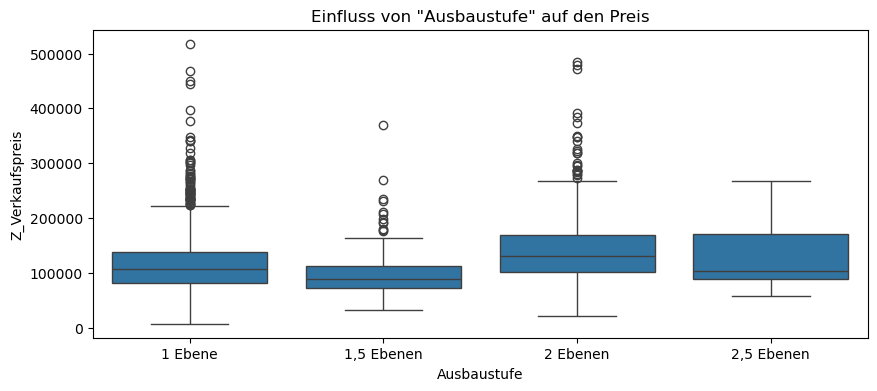

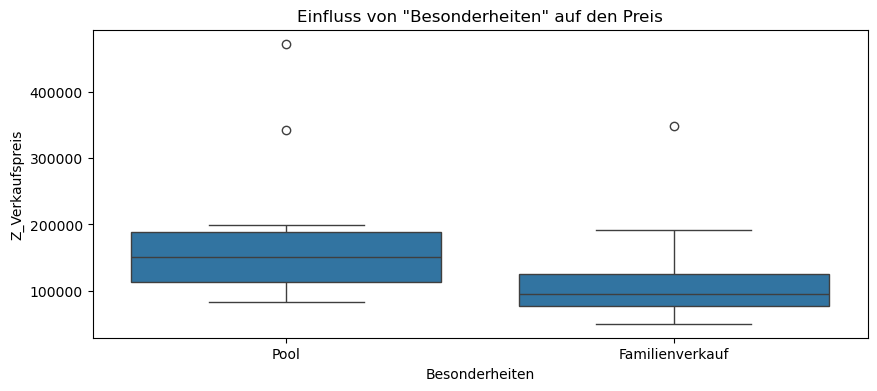

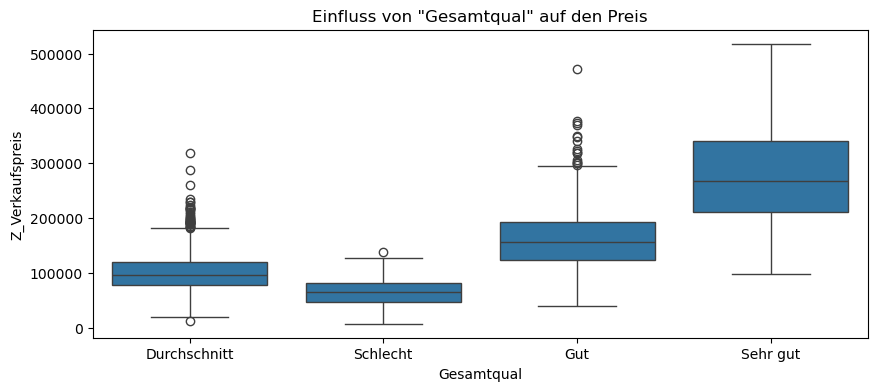

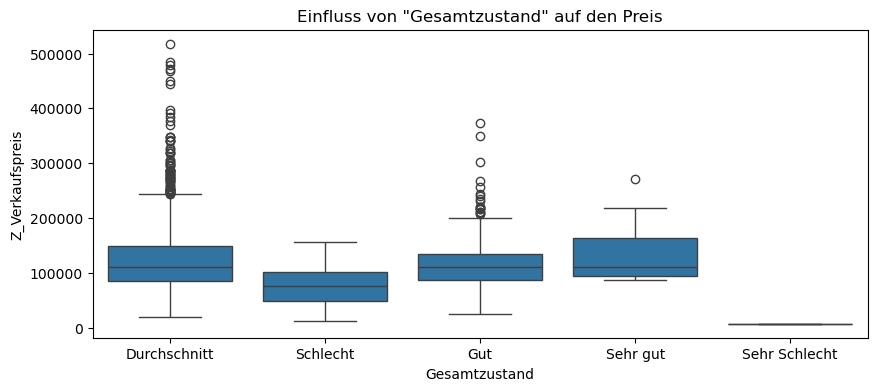

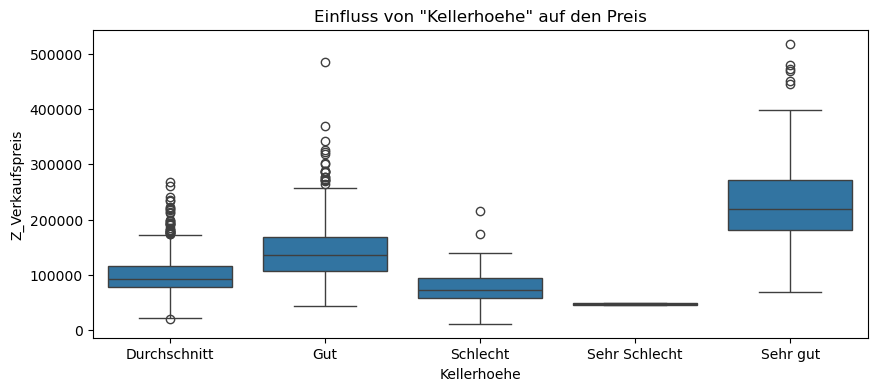

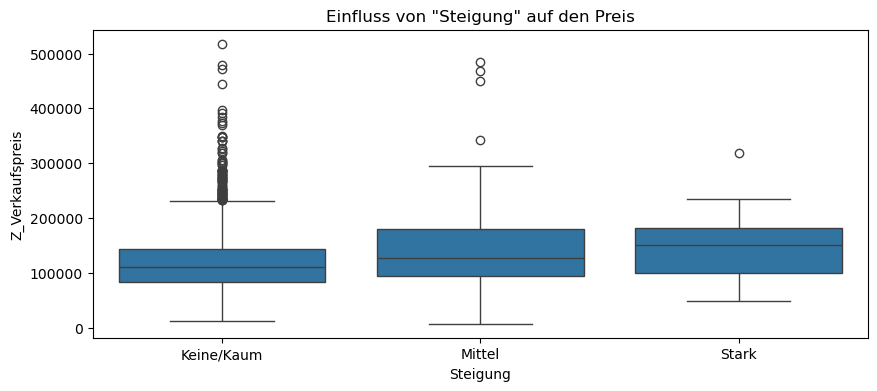

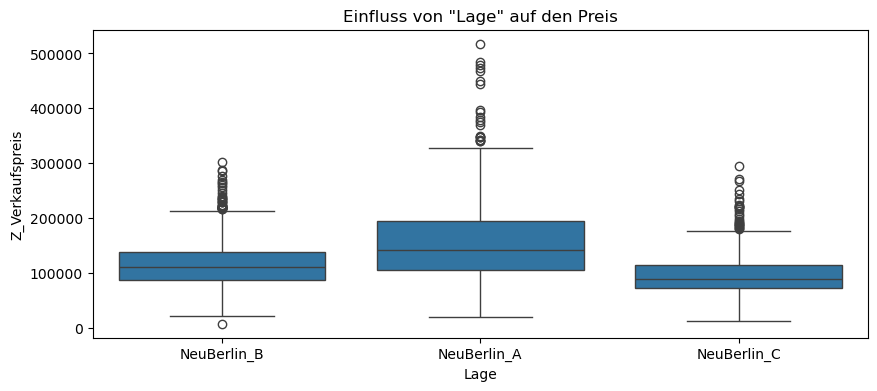

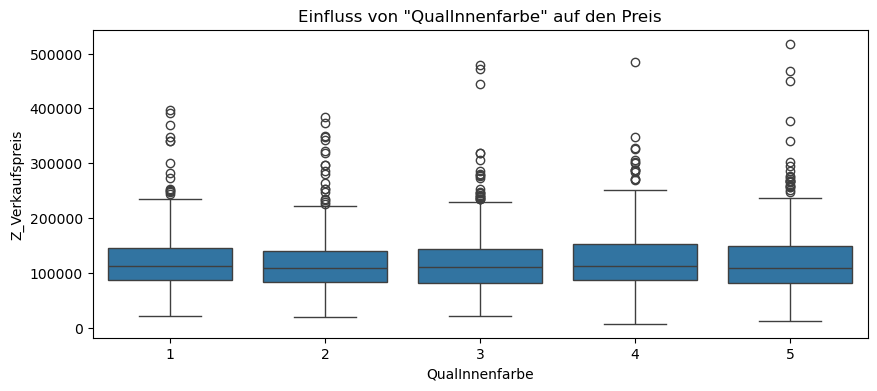

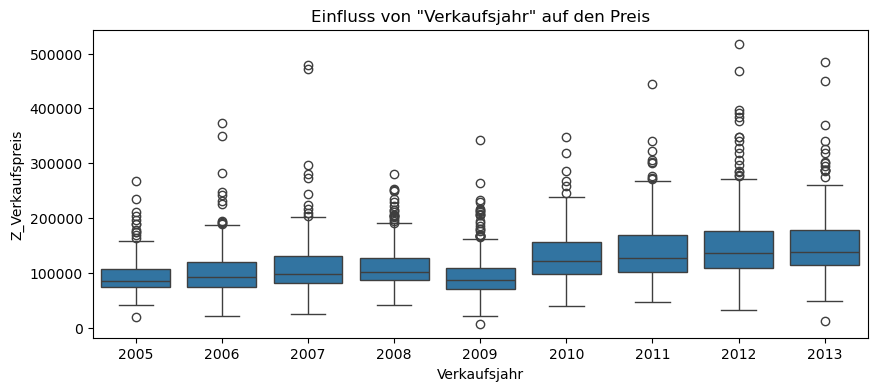

In [9]:
# Wähle kategorische Spalten
categorical = ['Ausbaustufe', 'Besonderheiten', 'Gesamtqual', 'Gesamtzustand', 'Kellerhoehe', 'Steigung', 'Lage', 'QualInnenfarbe', 'Verkaufsjahr']

# Für jede Kategorie einen Plot machen
for column in categorical:
    plt.figure(figsize=(10, 4))
    # Sortierung hilft beim Lesen (optional)
    sns.boxplot(x=column, y='Z_Verkaufspreis', data=data_train)
    plt.title(f'Einfluss von "{column}" auf den Preis')
    plt.show()

**2. Kategorische Einflüsse (Boxplots):**
- **Qualität:** Der Boxplot zu `Gesamtqual` zeigt, dass die Gesamtqualität des Hauses einen Unterschied macht. Je besser die Qualität, umso höher ist der Median-Preis. Die Boxen überlappen sich zudem kaum, was bedeutet, dass dieses Merkmal eine hohe Trennschärfe besitzt
- **Trend und Plausibilität:** Grundsätzlich ist der erwartete Trend erkennbar: Je besser der Zustand (von "Schlecht" zu "Sehr gut"), desto höher tendenziell der Median des Z_Verkaufspreis
    - Besonders die Kategorie "Sehr gut" hebt sich in beiden Merkmalen deutlich durch ein höheres Preisniveau und eine größere Varianz nach oben ab
    - Problem der Unterrepräsentation: Die Kategorie "Sehr Schlecht" zeigt in beiden Plots fast keine Varianz. Dies deutet stark darauf hin, dass hier nur extrem wenige Beobachtungen vorliegen
    - Diese spärliche Besetzung ist für ein Klassifikations-/Regressionsmodell problematisch, da es zu Overfitting auf diese wenigen Ausreißer führen kann
    - Um das Modell zu stabilisieren, sollten die Kategorie "Sehr Schlecht" mit der Kategorie "Schlecht" zusammengefasst werden
- **Steigung:** Häuser mit "Starker" `Steigung` haben einen etwas höheren Median als flache Grundstücke. Dies könnte mit einer besseren Aussicht (Hanglage) korrelieren
-  **Lage:** Geringer Einfluss
- **Besonderheiten:** Der Plot zu `Besonderheiten` zeigt nur "Pool" und "Familienverkauf". Ein Blick in die Rohdaten zeigt viele `NaN`-Werte
    - *Interpretation:* `NaN` bedeutet wahrscheinlich, dass ein Haus keine Besonderheit hat
    - Während der Data Preparaion sollten diese Zeilen nicht gelöscht werden, stattdessen sollten die `NaN`-Werte durch eine Kategorie wie "Standard" ersetzt werden
    - Ein Pool scheint den Preis signifikant zu heben, erkennbar durch den höheren Median
- **Kellerhöhe:** Es ist eine positive Tendenz erkennbar. Kategorien wie "Sehr gut" korrelieren mit deutlich höheren Verkaufspreisen als "Durchschnitt" oder "Schlecht"
    - Auffällig ist die hohe Varianz bei "Sehr gut": Eine sehr gute Kellerhöhe ermöglicht hohe Preise, garantiert sie aber nicht (die Box ist sehr lang gestreckt)
    - Die Kategorie "Sehr Schlecht" wird im Plot lediglich als flache Linie dargestellt. Dies ist ein Indikator für eine extrem geringe Fallzahl. Da diese Kategorie statistisch nicht signifikant ist, sollte sie mit der Kategorie "Schlecht" zusammengefasst werden, ähnlich 
- **Verkaufsjahr:** Geringe Tendenz, dass später verkaufte Häuser auch teurer verkauft wurden
    - *Interpretation*: Umso später ein Haus verkauft wird, umso neuer und somit moderner wird es vermutlich sein
    - Häuser im Jahr 2009 scheinen eine Ausnahe darzustellen, da hier der Verkaufspreis im Median sogar geringer ist als im Vorjahr
    - *Handlung:* Ob dies tatsächlich der Fall ist, beispielsweise durch die Finanzkriese zu dieser Zeit bedingt, ist der Preis pro Quadratmeter zu begutachten, um auszuschließen, dass 2009 nicht durch Zufall nur günstigere Häuser verkauft wurden (somit Selection Bias vermeiden)
- **Ohne/Wenig Einfluss:**
    - Das Merkmal `Ausbaustufe` scheint nicht logisch mit dem Verkaufspreis korreliert zu sein, die Boxplots zeigen, dass mehr Ebenen nicht direkt einen höheren Verkaufspreis zur folge haben
    - Das Merkmal `QualInnenfarbe` hat den Boxplots zu urteilen keinen Einfluss auf den Verkaufspreis

## 2.1 Betrachtung der Daten ohne Außreiser in `Grundstueck_qm`

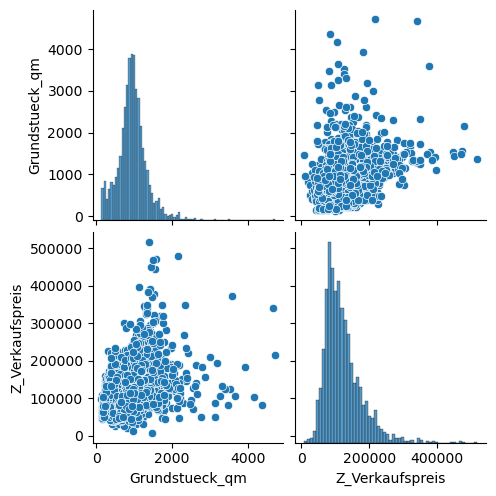

In [10]:
land_vs_price = ['Grundstueck_qm', 'Z_Verkaufspreis']

# Filtering: Wir behalten nur Einträge unter 5.000 qm
data_train_filtered = data_train[data_train['Grundstueck_qm'] < 5000].copy()

scatterplot = sns.pairplot(data_train_filtered[land_vs_price])
plt.show()

**Auswertung:**
Wie vermutet, wird nun eine positive Korrelation sichtbar. Tendenziell führen größere Grundstücke zu höheren Verkaufspreisen. Trotz des erkennbaren Trends ist die Streuung der Datenpunkte sehr hoch. Dies deutet darauf hin, dass die Grundstücksgröße zwar einen Einfluss auf den Basispreis hat, aber alleine als Merkmal nicht aussagekräftig genug zur Vorhersage des Verkaufspreises ist. In der Phase der Data Preparation sind diese Außreiser tatsächlich zu filern.

## 2.2 Analyse des Preisabfalls im Verkaufsjahr 2009

Zuvor betrachten wir, ob die in 2009 verkauften Häuser nicht zufällig eine geringere Wohnfläche hatten, im Vergleich zu den restlichen Jahren.

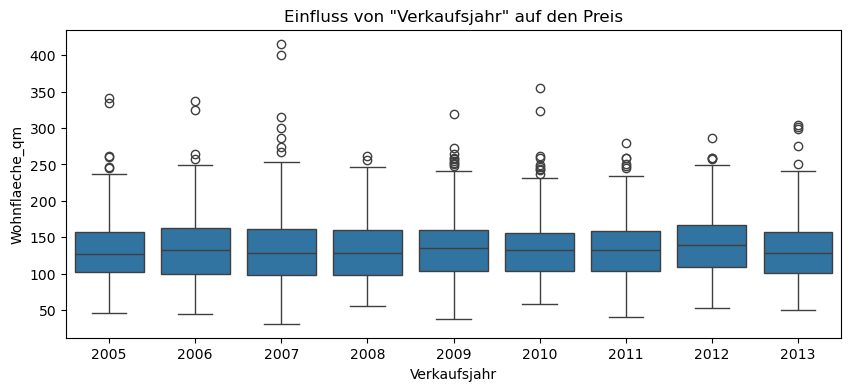

In [11]:
plt.figure(figsize=(10, 4))
sns.boxplot(x='Verkaufsjahr', y='Wohnflaeche_qm', data=data_train)
plt.title(f'Einfluss von "Verkaufsjahr" auf den Preis')
plt.show()

Nun betrachten wir den Quadratmeterpreis in den verschiedenen Verkaufsjahren.

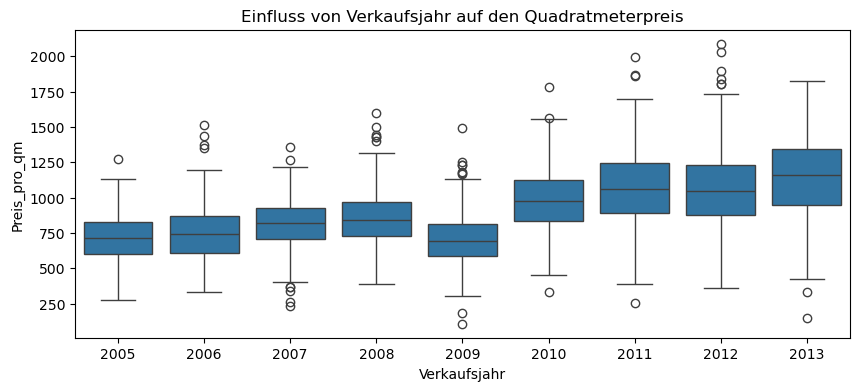

In [12]:
data_train['Preis_pro_qm'] = data_train['Z_Verkaufspreis'] / data_train['Wohnflaeche_qm']

plt.figure(figsize=(10, 4))
sns.boxplot(x='Verkaufsjahr', y='Preis_pro_qm', data=data_train)
plt.title('Einfluss von Verkaufsjahr auf den Quadratmeterpreis')
plt.show()

**Auswertung:**
Der Preisrückgang im Jahr 2009 scheint tatsächlich durch eine Finanzkriese bedingt zu sein, da der Quadratmeterpreis sinkt, während die verkaufte Wohnfläche konstant bleibt.

## 2.3 Fehlende Werte bei `Besonderheiten`

In [13]:
# NaN Werte durch 'Standard' ersetzen
data_train['Besonderheiten'] = data_train['Besonderheiten'].fillna('Standard')

# Check
print(data_train['Besonderheiten'].value_counts())

Besonderheiten
Standard           2331
Familienverkauf      43
Pool                 10
Name: count, dtype: int64


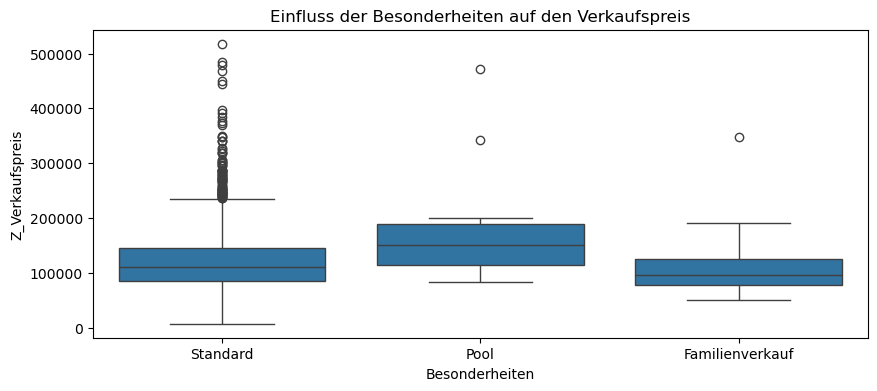

In [14]:
plt.figure(figsize=(10, 4))
sns.boxplot(x='Besonderheiten', y='Z_Verkaufspreis', data=data_train)
plt.title('Einfluss der Besonderheiten auf den Verkaufspreis')
plt.show()

## 2.4 Erkenntnis nach Binning 

Folgende Zelle wurde als Teil der Data Preparation ausgeführt.

In [15]:
# Definition des Mappings: "Sehr Schlecht" wird zu "Schlecht"
cleanup_map = {'Sehr Schlecht': 'Schlecht'}

data_train['Kellerhoehe'] = data_train['Kellerhoehe'].replace(cleanup_map)

print("Werte für Kellerhoehe:", data_train['Kellerhoehe'].unique())

Werte für Kellerhoehe: ['Durchschnitt' 'Gut' 'Schlecht' 'Sehr gut' nan]


Hier zeigt sich, dass Häuser ohne Keller für das Merkmal `Kellerhoehe` den Wert `NaN` eingetragen haben, somit erschienen diese Häuser bisher nicht in dem Boxplot, welcher den Zusammenhang zwischen Kellerhöhe und Verkaufspreis untersuchte. So wie zuvor für das Merkmal `Besonderheiten` geschehen sind nun auch hier die `NaN`-Werte einer Kategorie zuzuordnen.

In [16]:
data_train['Kellerhoehe'] = data_train['Kellerhoehe'].fillna('Kein Keller')

print("Werte für Kellerhoehe:", data_train['Kellerhoehe'].unique())

Werte für Kellerhoehe: ['Durchschnitt' 'Gut' 'Schlecht' 'Sehr gut' 'Kein Keller']


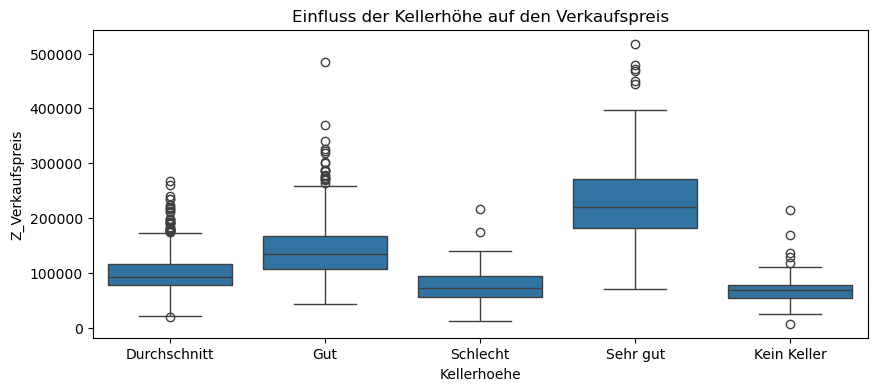

In [17]:
plt.figure(figsize=(10, 4))
sns.boxplot(x='Kellerhoehe', y='Z_Verkaufspreis', data=data_train)
plt.title('Einfluss der Kellerhöhe auf den Verkaufspreis')
plt.show()

**Auswertung:** Der Plot zeigt nun, dass Häuser ohne Keller einen geringeren Verkaufspreis haben zu scheinen, oder zumindest ähnlich zu Häusern mit schlechter Kellerhöhe. Diese Auswertung entspricht der Intuition.

## 2.5 Analyse der numerischen Merkmale für Feature Scaling
Um eine fundierte Entscheidung über das Feature Scaling treffen zu können, wurden die Schiefe (Skewness) und die deskriptiven Statistiken der numerischen Merkmale analysiert.

In [23]:
print('Skewness:')
print(data_train[['Baujahr', 'EG_qm', 'Wohnflaeche_qm', 'Grundstueck_qm']].skew())
print('Description:')
print(data_train[['Baujahr', 'EG_qm', 'Wohnflaeche_qm', 'Grundstueck_qm']].describe())

Skewness:
Baujahr          -0.535114
EG_qm             1.085505
Wohnflaeche_qm    1.017327
Grundstueck_qm    2.034240
dtype: float64
Description:
           Baujahr        EG_qm  Wohnflaeche_qm  Grundstueck_qm
count  2374.000000  2374.000000     2374.000000     2374.000000
mean   1971.042544   104.681550      136.493260      976.419966
std      29.634184    34.118094       45.382624      447.154026
min    1875.000000    31.000000       31.000000      132.000000
25%    1953.000000    80.000000      101.000000      746.000000
50%    1973.000000    98.000000      132.000000      941.000000
75%    1999.000000   124.000000      160.000000     1146.000000
max    2013.000000   355.000000      416.000000     4706.000000


**Auswertung:** Da die Wertebereiche der Merkmale stark variieren (z.B. Baujahr ~2000 vs. Wohnfläche ~100), ist eine Skalierung für viele Machine-Learning-Algorithmen (wie Lineare Regression) zwingend erforderlich. Da die Merkmale `EG_qm`, `Wohnflaeche_qm` und `Grundstueck_qm` eine deutliche Rechtsschiefe aufweisen, könnte eine Log-Transformation in einer fortgeschrittenen Iteration bessere Ergebnisse liefern, für den Anfang ist der StandardScaler jedoch ausreichend.

# 3. Data Preparation

## 3. Filtern der Außreiser von `Grundstueck_qm`

Da sich das Filtern der Außreißer in Kapitel 2.1 als sinnvoll erwiesen hat, wenden wir den Filter nun auf unsere tatsächlichen Daten an.

In [18]:
# Speichern der ursprünglichen Anzahl, um zu sehen, wie viele Datenpunkte entfernt werden
rows_before = data_train.shape[0]

# Filtern
data_train = data_train[data_train['Grundstueck_qm'] < 5000]

rows_after = data_train.shape[0]
print(f"Filterung angewendet.")
print(f"Zeilen davor: {rows_before}")
print(f"Zeilen danach: {rows_after}")
print(f"Gelöschte Ausreißer: {rows_before - rows_after}")

Filterung angewendet.
Zeilen davor: 2384
Zeilen danach: 2374
Gelöschte Ausreißer: 10


## 3.1 Binning von Kategorien mit wenigen Datenpunkten

In [19]:
# "Sehr Schlecht" wird zu "Schlecht"
cleanup_map = {'Sehr Schlecht': 'Schlecht'}

data_train['Gesamtzustand'] = data_train['Gesamtzustand'].replace(cleanup_map)

print("Werte für Gesamtzustand:", data_train['Gesamtzustand'].unique())

Werte für Gesamtzustand: ['Durchschnitt' 'Schlecht' 'Gut' 'Sehr gut']


Für die Kellerhöhe wurde dieser Schritt bereits in Kaptiel 2.4 erledigt.

## 3.2 Entfernen Irellevanter Merkmale

Da die Merkmale Ausbaustufe, so wie die Qualität der Innenfarbe keinen logischen Zusammenhang, oder Mehrwert in der Analyse zeigten, werden diese entfernt.

In [20]:
drop_cols = ['Ausbaustufe', 'QualInnenfarbe']

data_train = data_train.drop(drop_cols, axis=1, errors='ignore')

## 3.3 Feature-Engineering "Preis pro Quadratmeter"

Um die Datenqualität zu überprüfen, wurde temporär das Merkmal `Preis_pro_qm` abgeleitet (Verkaufspreis / Wohnfläche). Da dieses Merkmal den Zielwert `Z_Verkaufspreis` direkt beinhaltet, wurde es ausschließlich für die Analyse und Bereinigung verwendet und nicht als Feature in das Training der Vorhersagemodelle aufgenommen, um Data Leakage zu vermeiden. Somit wird dieses Feature wieder entfernt.

In [21]:
data_train = data_train.drop('Preis_pro_qm', axis=1, errors='ignore')

print("Spalte 'Preis_pro_qm' erfolgreich entfernt." if 'Preis_pro_qm' not in data_train.columns else "Fehler beim Entfernen.")

Spalte 'Preis_pro_qm' erfolgreich entfernt.


## 3.4 Encoding Kategorischer Merkmale

Um die kategorischen Merkmale für die Modellierung vorzubereiten, werden diese mittels One-Hot-Encoding für nominale Merkmale und Label-Encoding für ordinale Merkmale in numerische Merkmale umgewandelt. Dies ermöglicht es den Modellen, die kategorialen Informationen effektiv zu nutzen.

In [22]:
# Definition der Mappings für Ordinale Merkmale
quality_map = {'Schlecht': 1, 'Durchschnitt': 2, 'Gut': 3, 'Sehr gut': 4}
steigung_map = {'Keine/Kaum': 1, 'Mittel': 2, 'Stark': 3}
keller_map = {'Kein Keller': 0, 'Schlecht': 1, 'Durchschnitt': 2, 'Gut': 3, 'Sehr gut': 4}

# Anwenden der Ordinalen Encodings
data_train['Gesamtqual'] = data_train['Gesamtqual'].map(quality_map)
data_train['Gesamtzustand'] = data_train['Gesamtzustand'].map(quality_map)
data_train['Kellerhoehe'] = data_train['Kellerhoehe'].map(keller_map)
data_train['Steigung'] = data_train['Steigung'].map(steigung_map)

# Nominal Encoding (One-Hot Encoding) für 'Besonderheiten' und 'Lage'
# drop_first=True um Multikollinearität zu vermeiden (Dummy Trap)
data_train = pd.get_dummies(data_train, columns=['Besonderheiten', 'Lage'], drop_first=True)

# Überprüfung der Datentypen und ersten Zeilen
print(data_train.info())
data_train.head()

<class 'pandas.core.frame.DataFrame'>
Index: 2374 entries, 0 to 2383
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   A_Index                  2374 non-null   int64
 1   Baujahr                  2374 non-null   int64
 2   EG_qm                    2374 non-null   int64
 3   Gesamtqual               2374 non-null   int64
 4   Gesamtzustand            2374 non-null   int64
 5   Grundstueck_qm           2374 non-null   int64
 6   Kellerhoehe              2374 non-null   int64
 7   Steigung                 2374 non-null   int64
 8   Umgebaut                 2374 non-null   int64
 9   Verkaufsjahr             2374 non-null   int64
 10  Wohnflaeche_qm           2374 non-null   int64
 11  Z_Verkaufspreis          2374 non-null   int64
 12  Besonderheiten_Pool      2374 non-null   bool 
 13  Besonderheiten_Standard  2374 non-null   bool 
 14  Lage_NeuBerlin_B         2374 non-null   bool 
 15  Lage_NeuB

,A_Index,Baujahr,EG_qm,Gesamtqual,Gesamtzustand,Grundstueck_qm,Kellerhoehe,Steigung,Umgebaut,Verkaufsjahr,Wohnflaeche_qm,Z_Verkaufspreis,Besonderheiten_Pool,Besonderheiten_Standard,Lage_NeuBerlin_B,Lage_NeuBerlin_C
0,1710,1960,166,2,2,1428,2,1,1960,2009,166,100088,False,True,True,False
1,1310,1982,151,2,2,2365,3,2,1982,2006,151,145148,False,True,True,False
2,2563,1925,84,1,1,1004,1,3,1953,2011,84,48860,False,True,False,False
3,373,1968,95,2,2,1314,2,1,1968,2006,95,72349,False,True,False,True
4,1464,1979,133,3,3,1080,3,1,2007,2007,133,138313,False,True,False,True


## 3.5 Feature Scaling
Die numerischen Merkmale weisen unterschiedliche Wertebereiche und Verteilungen auf. Um die Leistung der Machine-Learning-Modelle zu verbessern, wird ein Feature Scaling durchgeführt. Hierbei wird der StandardScaler verwendet, der die Merkmale so transformiert, dass sie einen Mittelwert von 0 und eine Standardabweichung von 1 aufweisen.

In [24]:
from sklearn.preprocessing import StandardScaler

# Numerische Spalten definieren
numerical_cols = ['Baujahr', 'EG_qm', 'Wohnflaeche_qm', 'Grundstueck_qm', 'Verkaufsjahr']

# Scaler initialisieren und anwenden
scaler = StandardScaler()
data_train[numerical_cols] = scaler.fit_transform(data_train[numerical_cols])

# Ergebnis überprüfen
print("Mittelwerte nach Scaling (sollten ~0 sein):\n", data_train[numerical_cols].mean())
print("\nStd-Abweichung nach Scaling (sollte ~1 sein):\n", data_train[numerical_cols].std())
data_train.head()

Mittelwerte nach Scaling (sollten ~0 sein):
 Baujahr          -9.566437e-16
EG_qm            -1.870637e-16
Wohnflaeche_qm   -2.394415e-17
Grundstueck_qm    5.387434e-17
Verkaufsjahr      7.931501e-15
dtype: float64

Std-Abweichung nach Scaling (sollte ~1 sein):
 Baujahr           1.000211
EG_qm             1.000211
Wohnflaeche_qm    1.000211
Grundstueck_qm    1.000211
Verkaufsjahr      1.000211
dtype: float64


,A_Index,Baujahr,EG_qm,Gesamtqual,Gesamtzustand,Grundstueck_qm,Kellerhoehe,Steigung,Umgebaut,Verkaufsjahr,Wohnflaeche_qm,Z_Verkaufspreis,Besonderheiten_Pool,Besonderheiten_Standard,Lage_NeuBerlin_B,Lage_NeuBerlin_C
0,1710,-0.372707,1.797620,2,2,1.010111,2,1,1960,-0.049963,0.650314,100088,False,True,True,False
1,1310,0.369835,1.357878,2,2,3.106027,3,2,1982,-1.212817,0.319721,145148,False,True,True,False
2,2563,-1.554024,-0.606303,1,1,0.061692,1,3,1953,0.725274,-1.156926,48860,False,True,False,False
3,373,-0.102692,-0.283826,2,2,0.755112,2,1,1968,-1.212817,-0.914491,72349,False,True,False,True
4,1464,0.268579,0.830188,3,3,0.231692,3,1,2007,-0.825199,-0.076990,138313,False,True,False,True
